**AE의 특징 : 기본적으로 RNN과 같이 Dense층으로 구성 되어져 있다. 하지만 구조상 일반적으로(아닐 수도 있음) 대칭이고, 잠재 공간 이라는 층이 존재 한다. 또한 잠재 공간 벡터를 복구하는 구간이 있다.**

# AutoEncoder

입력 데이터를 효율적으로 **압축, 복원** 하여 학습에 용이하게 하거나 노이즈를 제거.

<img src="../../img/_09_AE/_09_AE_02.png" height="500">

# AE의 구조

1. Encoder
    1. 입력 데이터를 저차원의 벡터로 매핑
    2. 특성의 추출 구간
2. Latent Space(잠재 공간) : 입력 데이터를 축약하고 있는 특성 벡터
3. Decoder
    1. 인코더와 대칭
    2. 복원하는 구간

## Encoder

- 차원 축소
- 일종의 Trade Off 가 있다. (잠재공간의 차원을 높일 것인가, 특성을 얼마나 압축할 것인가.)

## Latent Space(Code 라고도 불리운다.)?

- 입력데이터의 중요한 특성을 반영하고 있다.
- 입력 데이터에 대한 압축 표현(**벡터**) : 차원의 저주를 완화시킨다.

## Decoder

- 생성형 모델(잠재공간을 다시 복구하는 과정에서 이미지가 생성)

## Loss

$\mathscr{L} = \frac{1}{n} \sum({x_i - \hat{x_i})^2}$

- 재 구성과정의 오차의 최소화
- MSE 또는 CEE 등이 쓰인다.

여기서 $x_i$  는 입력 값이지만 예측에 대한 정답 라벨이기도 하다.

# AE 과정 및 응용

1. $z = f(x)$ : 인코더 부분
2. $\hat x = g(z)$ : 디코더 부분
3. $\mathscr{L} = \frac{1}{n} \sum({x_i - \hat{x_i})^2}$ : MSE or CEE

인코더 부분만 쓰이기도하다.

## 응용

- 입력 데이터의 압축 및 복원 → 효율적인 데이터 저장 및 전송
- **차원의 축소** (PCA 와 비슷하나, 좀더 비선형적이다)
    
    
    | 특징 | PCA | AE |
    | --- | --- | --- |
    | 변환 | 선형 | 비선형 |
    | 구현 | 공분산, 행렬의 고유벡터 | NN기반 Encoder, Decoder |
    | 계산 복잡 | 낮음 | 복잡 |
    | 해석 | 용이 | 어려움 |
    | 유연성  | 낮다  | 높다 |
- **노이즈 제거** → 중요 특성을 추출 하여 노이즈를 제거한다.
    1. 입력 값에 노이즈를 추가해 AE의 입력 값으로 넣는다
    2. 출력 과 비교할 정답 라벨로 노이즈가 추가되기 전의 입력 데이터로 넣는다
    
    $x_i$ : 원래의 입력
    
    $x'_i$ : 노이즈 된 입력
    
    순 전파 시 입력 데이터를 $x'_i$ 이용,
    
    정답 라벨과 Loss 값을 구할 때 $x_i$ 이용.
    
    - 새로운 데이터가 들어올 때 노이즈가 제거 된다.
- **추천 시스템** (수천가지의 특성 들을 잠재공간에 넘기는 과정)
- **이상치 탐지**
    1. 일반 적인 방법으로 AE학습
    2. 새로운 데이터를 넣어 재구성손실을 이용하여 이상치를 탐지한다

# 실습 1 Mnist data를 이용한 AE

- 라이브러리 불러오기
    
    ```python
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dense, Input, Embedding, Flatten # Input 모델의 입력을 정의할 때 
    from tensorflow.keras.datasets import mnist
    from tensorflow.keras.regularizers import l1 # 정규화 과적합 방지
    from tensorflow.keras.optimizers import Adam
    
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    ```
    
- 전처리
    
    ```python
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Input scaling
    x_train1 = x_train.astype('float32')/255
    x_test1 = x_test.astype('float32')/255
    
    x_train = x_train1.reshape((60000, 28*28))
    x_test = x_test1.reshape((10000, 28*28))
    ```
    
- **모델 정의**
    
    ```python
    input_size = 784
    hidden_size = 128
    code_size = 32 # 잠재 공간 벡터의 크기
    
    input_img = Input(shape=(input_size,)) # 인풋
    
    hidden_1 = Dense(hidden_size, activation='relu')(input_img) # 인코더 부분
    
    code = Dense(code_size, activation='relu')(hidden_1) # 잠재 공간
    
    hidden_2 = Dense(hidden_size, activation='relu')(code) # 디코더 부분(인코더와 같다)
    output_img = Dense(input_size, activation='sigmoid')(hidden_2)
    # 인코더 부분과 디코더 부분 둘다 있어야 한다면,
    # 출력 층의 사이즈는 입력층의 사이즈와 같아야 한다.
    
    # 인코더부분과 디코더 부분의 결합
    autoencoder = Model(input_img, output_img)
    ```
    
- 모델 테스트
    
    ```python
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=5)
    test_loss = autoencoder.evaluate(x_test, x_test)
    print("Test loss:", test_loss)
    
    '''
    Test loss: 0.00808830838650465
    '''
    ```
    
    test loss : $\sqrt{0.0080}$ 즉, 정답 라벨과 예측 값의 차이의 평균은 0.08 이고 이는 예측 값과 실제 값의 차이와 근사치이다.
    
- **인코더 부분만 (latent space를 이용함) 을 이용한 예측모델 :**
    
    ```python
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras import optimizers
    
    encoder = Model(inputs=input_img, outputs=code)
    
    # encode 훈련셋
    X_train_encode = encoder.predict(x_train)  # 32차원의 저차원 벡터 생성
    # encode 검증셋
    X_test_encode = encoder.predict(x_test)
    
    # 단순히 시퀀셜한 구성으로 사용
    model = models.Sequential()
    model.add(layers.Dense(128, activation = 'relu', input_shape=(X_train_encode.shape[1],)))
    model.add(layers.Dense(10, activation = 'softmax'))
    ```
    
    ```python
    y_train_one_hot = to_categorical(y_train)
    y_test_one_hot = to_categorical(y_test)
    ```
    
    ```python
    rmsprop = optimizers.RMSprop(learning_rate=0.001)
    model.compile(optimizer=rmsprop,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train_encode, y_train_one_hot,
    										epochs=20, batch_size=128, validation_split = 0.2)
    ```
    
    > Epoch 1/20
    375/375 [==============================] - 2s 4ms/step - loss: 0.6694 - accuracy: 0.7985 - val_loss: 0.3348 - val_accuracy: 0.9012
    Epoch 2/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.3312 - accuracy: 0.8997 - val_loss: 0.3045 - val_accuracy: 0.9061
    Epoch 3/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.2654 - accuracy: 0.9206 - val_loss: 0.2145 - val_accuracy: 0.9368
    Epoch 4/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.2252 - accuracy: 0.9330 - val_loss: 0.1894 - val_accuracy: 0.9442
    Epoch 5/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1949 - accuracy: 0.9404 - val_loss: 0.1736 - val_accuracy: 0.9484
    Epoch 6/20
    375/375 [==============================] - 2s 4ms/step - loss: 0.1731 - accuracy: 0.9475 - val_loss: 0.1570 - val_accuracy: 0.9553
    Epoch 7/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1602 - accuracy: 0.9516 - val_loss: 0.1570 - val_accuracy: 0.9542
    Epoch 8/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1463 - accuracy: 0.9552 - val_loss: 0.1391 - val_accuracy: 0.9615
    Epoch 9/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1365 - accuracy: 0.9594 - val_loss: 0.1261 - val_accuracy: 0.9638
    Epoch 10/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1274 - accuracy: 0.9616 - val_loss: 0.1319 - val_accuracy: 0.9637
    Epoch 11/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1217 - accuracy: 0.9627 - val_loss: 0.1200 - val_accuracy: 0.9650
    Epoch 12/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1151 - accuracy: 0.9654 - val_loss: 0.1259 - val_accuracy: 0.9640
    Epoch 13/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1100 - accuracy: 0.9659 - val_loss: 0.1245 - val_accuracy: 0.9638
    Epoch 14/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1049 - accuracy: 0.9679 - val_loss: 0.1200 - val_accuracy: 0.9629
    Epoch 15/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.1002 - accuracy: 0.9691 - val_loss: 0.1221 - val_accuracy: 0.9648
    Epoch 16/20
    375/375 [==============================] - 1s 3ms/step - loss: 0.0975 - accuracy: 0.9700 - val_loss: 0.1207 - val_accuracy: 0.9658
    Epoch 17/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.0946 - accuracy: 0.9702 - val_loss: 0.1105 - val_accuracy: 0.9678
    Epoch 18/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.0916 - accuracy: 0.9715 - val_loss: 0.1187 - val_accuracy: 0.9653
    Epoch 19/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.0879 - accuracy: 0.9725 - val_loss: 0.1116 - val_accuracy: 0.9657
    Epoch 20/20
    375/375 [==============================] - 1s 4ms/step - loss: 0.0857 - accuracy: 0.9734 - val_loss: 0.1183 - val_accuracy: 0.9664
    > 

# 실습 2 : 영화 평가 를 이용한 추천 영화

- 라이브러리 불러오기
    
    ```python
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam
    ```
    
- 전처리
    
    ```python
    ratings = pd.read_csv('09_AE_03_RatingData.csv')
    ratings = ratings[['userId', 'movieId', 'rating']]
    
    ratings_matrix = ratings.pivot(# 각 영화를 피쳐로, 점수를 값으로
        index='userId',
        columns='movieId',
        values='rating')
    
    # 평가 되지 않은 항목은 0으로 weight 과 곱해질 때 이 피쳐와 weight 의 곱이 0으로 되기 때문
    ratings_matrix.fillna(0, inplace=True)
    
    # 정규화 ratings_matrix 는 약 10000개의 피쳐가 있다 (영화의 갯수 및 평)
    ratings_matrix = ratings_matrix.values / 5.0
    ```
    
- **모델 생성**
    
    ```python
    # 오토인코더 모델 생성
    input_layer = Input(shape=(ratings_matrix.shape[1],))
    encoded = Dense(512, activation='relu')(input_layer)
    
    encoded = Dense(256, activation='relu')(encoded) # 잠재 공간
    
    decoded = Dense(512, activation='relu')(encoded) # 디코더
    output_layer = Dense(ratings_matrix.shape[1],
                         activation='sigmoid')(decoded) # 평점이 0과 1 사이의 값이 되도록
    
    # 원본 평점과 예측 평점 간의 차이를 최소화하도록 학습 유도
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    ```
    
    ```python
    # 훈련 및 검증 데이터 분리
    x_train, x_val = train_test_split(ratings_matrix, test_size=0.2, random_state=42)
    ```
    
    ```python
    # 모델 학습
    # 입력 평점을 재구성하는 방법을 학습
    autoencoder.fit(x_train, x_train,epochs=50,batch_size=256,validation_data=(x_val, x_val))
    ```
    
    ```python
    # 모델 평가
    val_loss = autoencoder.evaluate(x_val, x_val)
    print("Validation loss:", val_loss)
    ```
    
    Validation loss: 0.0120133887976408 (Nice 한 결과)
    
    ```python
    # 평점 예측
    # 학습된 모델을 사용하여 사용자 평점 예측
    predicted_ratings = autoencoder.predict(ratings_matrix) * 5.0  # 스케일을 원래대로 복구
    ```
    
- 영화 추천
    
    ```python
    # 사용자가 아직 평가하지 않은 영화에 대한 추천 생성
    def generate_recommendations(user_id, predicted_ratings, ratings_matrix):
        user_ratings = ratings_matrix[user_id - 1]  # 사용자의 평점 데이터 가져오기 (인덱스는 0부터 시작하므로 -1)
        unseen_movies_idx = user_ratings == 0  # 사용자가 아직 평가하지 않은 영화 찾기
        predicted_ratings_for_user = predicted_ratings[user_id - 1]  # 사용자에 대한 예측 평점 가져오기
        recommended_movies = predicted_ratings_for_user[unseen_movies_idx]  # 아직 보지 않은 영화에 대한 예측 평점 가져오기
        top_recommended_movie_ids = recommended_movies.argsort()[::-1][:10]  # 상위 10개 추천 영화 선택
                                          # argsort()[::-1]는 평점을 내림차순으로 정렬,
                                          # 가장 높은 평점을 가진 10개의 영화 인덱스 반환
    
        # print(unseen_movies_idx) # 평점 0 True, 0이 아닌(평점이 있는 영화) index는 False
        return top_recommended_movie_ids
    
    # 예시: 사용자 1에 대한 영화 추천 생성
    user_id = 1
    recommendations = generate_recommendations(user_id, predicted_ratings, ratings_matrix)
            # user_id: 사용자 ID
            # predicted_ratings: 모델을 통해 생성된 예측 평점
            # ratings_matrix: 사용자-영화 평점 matrix(원 데이터) -평가하지 않은 영화(0값) 정보 포함
    print("Recommended movie IDs for user {}: {}".format(user_id, recommendations))
    ```
    
    Recommended movie IDs for user 1: [ 259  615 3402 3162 3168 3167 3166 3165 3164 3163]

# 오토인코더

- 압축한걸 왜 복원해~
- 저처원으로 압축 하여, 학습할떄 용이하게 한다.

입력 데이터를 효율적으로 압축 복원

인코더 와 디코더로 구성
  - 인코더 : 입력데이터를 latent space(잠재 공간)로 압축
  - 디코더 : 원본 데이터로 복원 
  - 압축, 복원중에 중요한 특성 학습
비 지도 학습 가능(목표는 입력값)(self supervised learning)

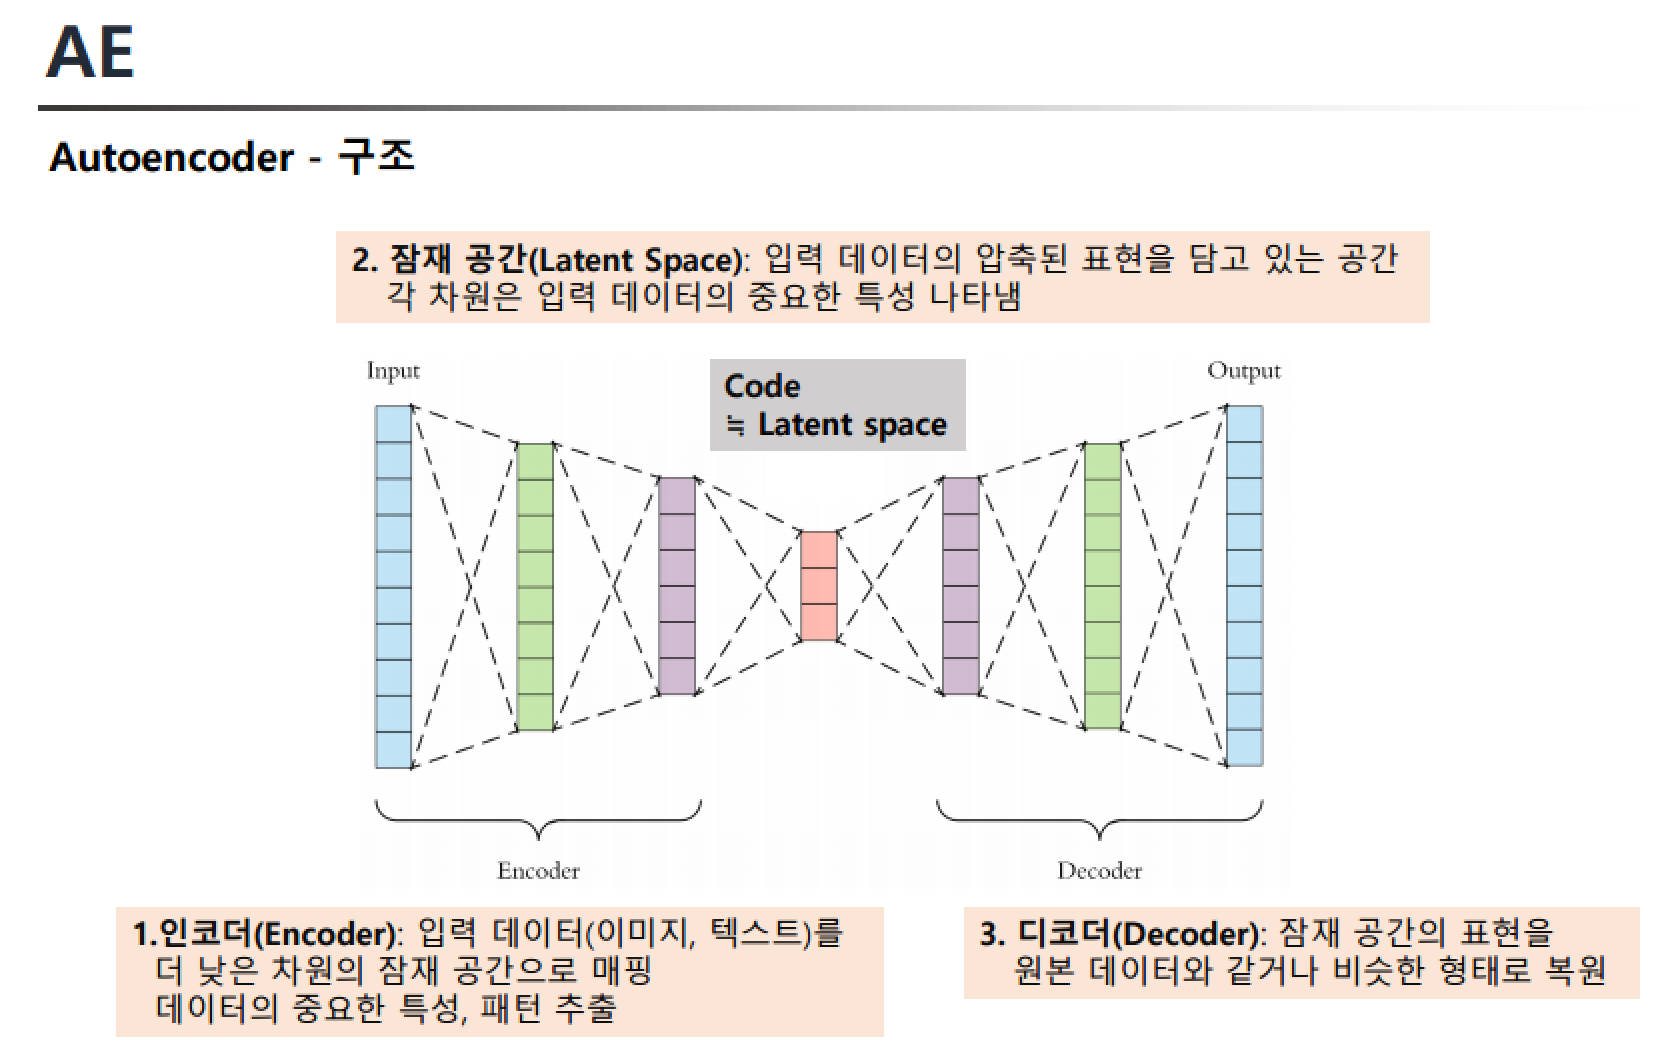

latent space : 입력 데이터에 대한 압축 표현 , 벡터이다.
  - 중요한 특성 반영
  - 차원 축소하여 데이터의 양을 감소
  - 차원의 저주 완화, 계산 효율

- 차원 축소 : bottle neck 처럼 생겼다.

인코더 $ z=f(x) $ <br>
디코더 $ \hat{x} = g(z) $ <br>

$ loss = \frac{1}{n} \sum(x_i - \hat{x_i})^2 $
  - 비용 함수 : 재구성 과정에서의 오차 측정 및 최소화
  - 입력 데이터에서 중요한 특성을 잘 보존하는 잠재 공간의 학습
MSE 나 CEE 등을 씀

# 활용

- 데이터 압축, 복원, 효율적인 데이터 저정 및 전송
- 차원 축소 : 주성분 분석과 비슷, 데이터 차원 축소(비선형 축소가능)
- 노이즈 제거
- 이상치 탐지
- 추천 시스템

# PCA

- PCA : 선형 분산정보 이용
- AE : 비선형 - (PCA 보다 복잡하다)
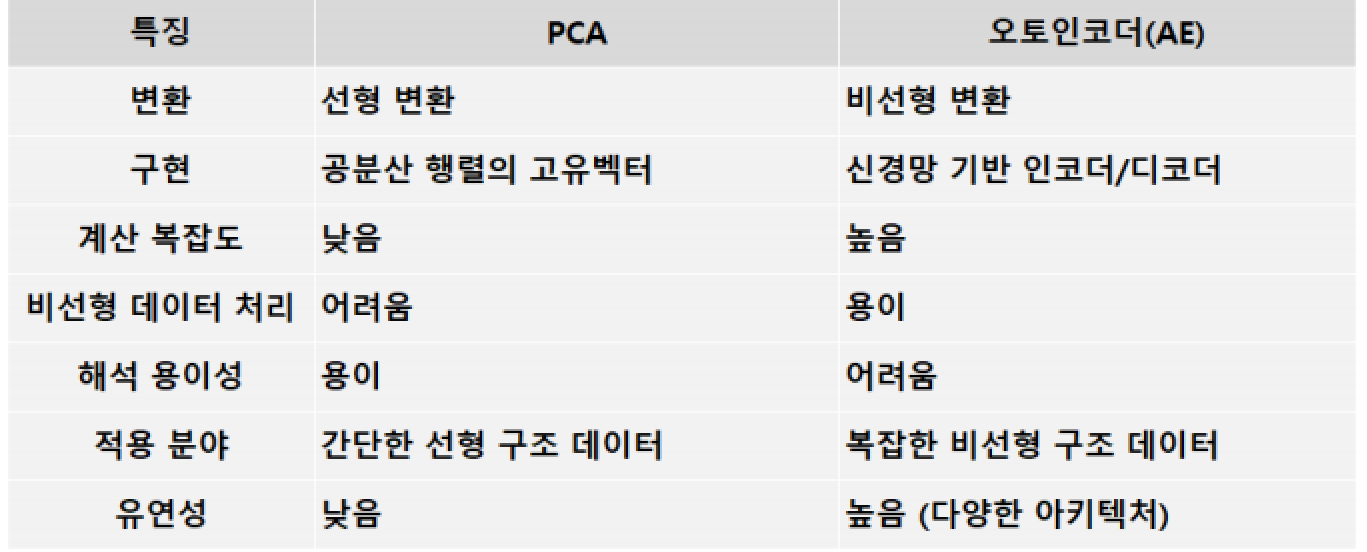

# 응용

- 디 노이징
- 아노말리 디텍션
- 추천 시스템

In [ ]:
#VAE 클래스는 Keras의 Model 클래스를 상속받아서 만들어진 클래스입니다. 이 클래스는 VAE 모델을 정의하고 학습하기 위한 기능을 포함합니다.
#__init__ 메서드: 클래스의 생성자로, encoder와 decoder 모델을 인수로 받습니다. 이 두 모델은 VAE의 핵심 구성 요소인 인코더와 디코더입니다.
#또한 **kwargs를 사용하여 추가 인수를 받을 수 있습니다.
class VAE(keras.models.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder  #loss 값을 모니터링 하는 요소
            self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
            self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")  #metrics 프로퍼티: VAE 모델의 성능을 모니터링하는 메트릭을 정의합니다. 이 모델은 총 손실 (total_loss), 재구성 손실 (reconstruction_loss), 및 KL-다이버전스 손실 (kl_loss)을 모니터링합니다.
        @property
        def metrics(self):
            return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            ]  #call 메서드는 모델을 호출할 때 실행되는 메서드입니다. 입력 이미지를 받아서 잠재 변수를 인코더로부터 추출하고, 해당 잠재 변수를 사용하여 이미지를 디코더로부터 재구성합니다.
            #input은 입력 이미지 데이터를 나타냅니다.
            #z_mean, z_log_var, z는 인코더로부터 얻은 잠재 변수의 평균, 로그 분산 및 샘플링된 잠재 변수를 나타냅니다.
            #reconstruction은 디코더로부터 재구성된 이미지를 나타냅니다.
        def call(self, input):
            z_mean, z_log_var, z = encoder(input)
            reconstruction = decoder(z)
            return z_mean, z_log_var, reconstruction 
            #train_step 메서드는 VAE 모델의 학습 단계를 정의합니다.
            #입력으로 데이터 (data)를 받아서 학습을 진행합니다.
            #tf.GradientTape() 내에서 재구성 손실과 KL-다이버전스 손실을 계산합니다.
            #reconstruction_loss는 재구성 손실을 계산하는 부분입니다. tf.losses.binary_crossentropy를 사용하여 재구성 손실을 계산하며, 이 값을 500으로 스케일링합니다.
            #kl_loss는 KL-다이버전스 손실을 계산하는 부분입니다. 이것은 VAE의 정규화 항으로, 잠재 변수의 분포와 정규 분포 간의 차이를 측정합니다.
            #total_loss는 재구성 손실과 KL-다이버전스 손실을 더한 총 손실입니다.
            #경사 하강법을 사용하여 총 손실을 최소화하도록 모델을 업데이트하고, 메트릭 값을 업데이트합니다.
            #최종적으로 업데이트된 메트릭 값을 딕셔너리로 반환합니다.
        def train_step(self, data):
            with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(500 * tf.losses.binary_crossentropy(data, reconstruction, axis=(1,2,3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)  return {m.name: m.result() for m in self.metrics}